## Library imports, data imports, and initialisations

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, probplot, skew
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

## Graphing Functions
These functions are going to be used later in the notebook for visualising various kinds of graphs.

In [2]:
# Generate a scatter plot comparing the xVar and yVar columns in df
def scatterPlot(df, xVar, yVar):
    plt.scatter(x = df[xVar], y = df[yVar])
    plt.title('Relationship between {} and {}'.format(xVar, yVar))
    plt.xlabel(xVar)
    plt.ylabel(yVar)
    plt.show()
    
    
# Generate a box plot comparing the xVar and yVar columns in df
def boxPlot(df, xVar, yVar):
    sns.boxplot(x = df[xVar], y = df[yVar])
    plt.title('Relationship between {} and {}'.format(xVar, yVar))
    plt.xlabel(xVar)
    plt.ylabel(yVar)
    plt.xticks(rotation = 90)
    plt.show()


# Generate histogram, and print values for skewness and kurtosis on it
def histogramPlot(s, ax = None, varName = ''):
    p = 0
    if ax is None:
        ax = plt.gca()
        p = 1
        
    if varName == '':
        varName = ' for {} values'.format(varName)
        
    f = sns.distplot(s, fit = norm, ax = ax)
    f.ticklabel_format(style = 'plain', axis = 'y')
    ax.set(title = 'Distribution plot'.format(varName), ylabel = 'Frequency')
    ax.add_artist(AnchoredText('Skewness: {:.4f}\nKurtosis: {:.4f}\n'.format(s.skew(), s.kurt()),
                               loc = 'upper right', frameon = False))
    
    # If not part of a subplot, print the figure
    if p == 1: plt.show()

    
# Generate probability plot (QQ-plot)
def probabilityPlot(s, ax = None, varName = ''):
    p = 0
    if ax is None:
        ax = plt.gca()
        p = 1
            
    if varName == '':
        varName = ' for {} values'.format(varName)
        
    f = probplot(s, plot = plt)
    ax.set(title = 'Probability plot'.format(varName))
    
    # If not part of a subplot, print the figure
    if p == 1: plt.show()


# Print the histogram abd probability plots as a side-by-side subplot
def histAndProbPlot(s, varName = ''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    plt.subplots_adjust(wspace = 0.4)
    histogramPlot(s, ax1, varName)
    probabilityPlot(s, ax2, varName)
    plt.show()
    
    
# Produce a graph with multiple horizontal box plots, bases on the columns specified (cols) in df
def boxPlotMultipleColumns(df, cols):
    sns.boxplot(data = df[cols], orient = 'h')
    plt.title('Distribution of numeric features')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    plt.xscale('log')

## Load in datasets
Read the CSV files for the training and testing data, then create a concatenated version for feature engineering.

In [3]:
# Load in the training and testing datasets
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Initial size of the datasets
print('Initial datasets:\ndf_train: {}\ndf_test: {}'.format(df_train.shape, df_test.shape))

# Save and remove the ID columns
trainingIDs = df_train['Id']
testingIDs = df_test['Id']

df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# Size of the datasets after removing the Id column
print('After removing Id columns:\ndf_train: {}\ndf_test: {}'.format(df_train.shape, df_test.shape))

Initial datasets:
df_train: (1460, 81)
df_test: (1459, 80)
After removing Id columns:
df_train: (1460, 80)
df_test: (1459, 79)


## Preliminary correlation inspections
Review correlation values between each set of characteristics, to identify if there are any redundant columns that could be dropped.

Characteristics with significant correlations:
GarageArea    GarageCars    0.882
GarageYrBlt   YearBuilt     0.826
TotRmsAbvGrd  GrLivArea     0.825
1stFlrSF      TotalBsmtSF   0.820
dtype: float64



<AxesSubplot:>

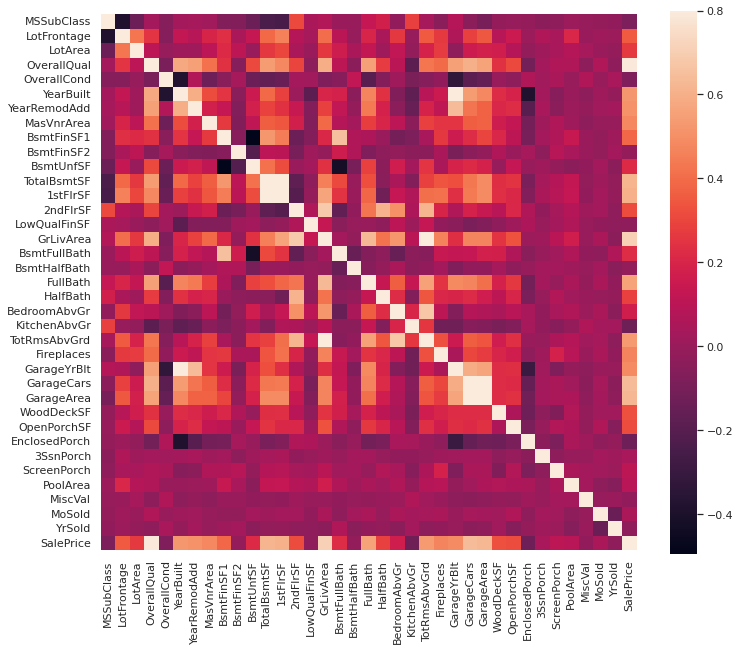

In [4]:
# Correlation matrix for all characteristics
corrMat = df_train.corr()

# Determine which correlations are significant, and drop the others
# Assuming correlation values >= 0.8 are significant
corrValues = corrMat.unstack().abs()
c = [corrValues.drop(i, inplace = True) for i, v in corrValues.items()
     if i[0] == i[1]                           # left and right index are the same
     or v < 0.8                                # Value is insignificant
     or (i[1], i[0]) in corrValues.index]      # repeated correlation values

# Sort and print the correlation values
print('Characteristics with significant correlations:\n{}\n'.format(corrValues.sort_values(ascending = False)))

# Print the figure
sns.set(font_scale = 1.0, rc = {'figure.figsize': (12, 10)})
sns.heatmap(corrMat, vmax = 0.8, square = True)

Very strong correlations between the following:
* GarageArea & GarageCars
* TotRmsAbvGrd & GrLivArea
* 1stFlrSF & TotalBsmtSF

I'll check which characteristic in each of the above pairs has a stronger correlation with SalePrice, and remove the other column.

Characteristics with correlation values over 0.5:
OverallQual    0.791
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
YearBuilt      0.523
YearRemodAdd   0.507
Name: SalePrice, dtype: float64



<AxesSubplot:>

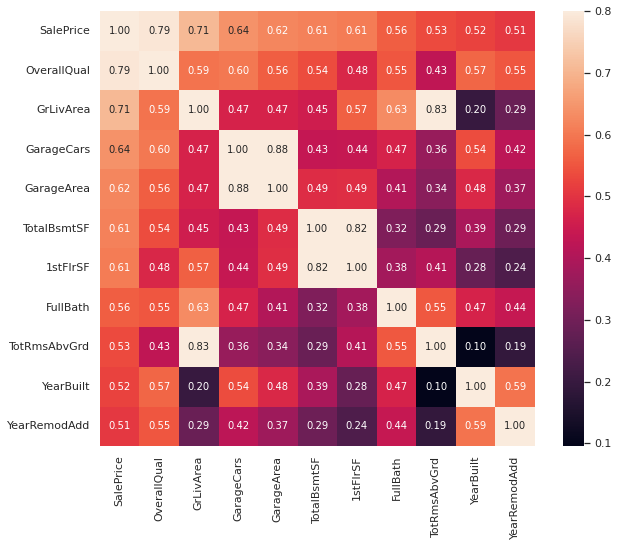

In [5]:
# Saleprice correlation matrix
#     Only including characteristics with correlation values over corrMin (relative to SalePrice)

corrMin = 0.5
corrSalePrice = corrMat[corrMat['SalePrice'].abs() >= corrMin]['SalePrice'].sort_values(ascending = False)
print('Characteristics with correlation values over {}:\n{}\n'.format(corrMin, corrSalePrice.drop('SalePrice')))

cols = corrSalePrice.index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale = 1.0, rc = {'figure.figsize': (10, 8)})
sns.heatmap(cm, cbar = True, annot = True, square = True,
            fmt = '0.2f', annot_kws = {'size': 10}, vmax = 0.8,
            xticklabels = cols.values, yticklabels = cols.values)

Referring to the previous strong correlations between characteristics (not inc. SalePrice):
* GarageArea (0.623) & GarageCars (0.640)
* TotRmsAbvGrd (0.534) & GrLivArea (0.709)
* 1stFlrSF (0.606) & TotalBsmtSF (0.614)

Therefore the following columns will be removed:
* GarageArea, TotRmsAbvGrd, 1stFlrSF

And the following characteristics are worth exploring further:
* GrLivArea, GarageCars, TotalBsmtSF, FullBath

In [6]:
df_train = df_train.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])
df_test = df_test.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])

## Remove outliers

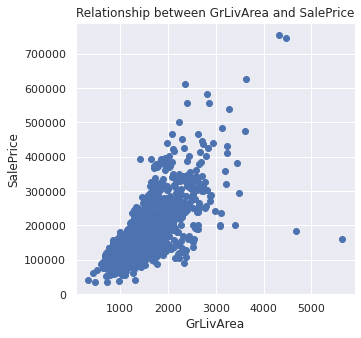

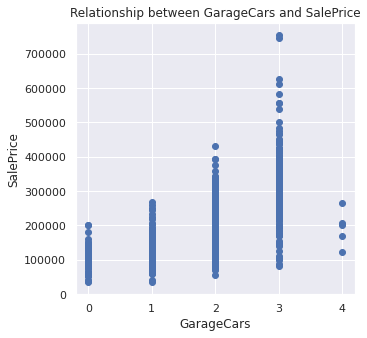

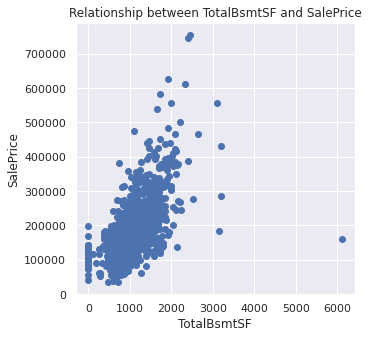

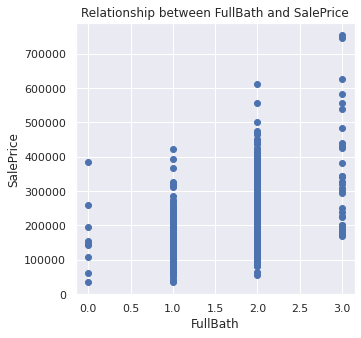

In [7]:
# Numerical values
variables = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.set(font_scale = 1.0, rc = {'figure.figsize': (5, 5)})
for var in variables:
    scatterPlot(df_train, var, 'SalePrice')

The relationships are as expected, though there are some outliers to remove. Whilst removing data can be hazardous, GrLivArea and TotalBsmtSF have obvious outliers to the right of the plot, and these will be excluded. However, I'll ignore outliers in characteristics not mentioned above (because their correlation to SalePrice is much lower, their outliers shouldn't have as much negative impact).

In [8]:
# Two outliers within the GrLivArea characteristic
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4500) & (df_train['SalePrice'] < 200000)].index)

# One outlier within the TotalBsmtSF characteristic
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 6000) & (df_train['SalePrice'] < 200000)].index)

df_train.reset_index(drop=True, inplace=True)

## Combine Datasets

Before combining the training and testing datasets, I need to seperate the target (SalePrice) column.

count     1458.000
mean    180932.919
std      79495.055
min      34900.000
25%     129925.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


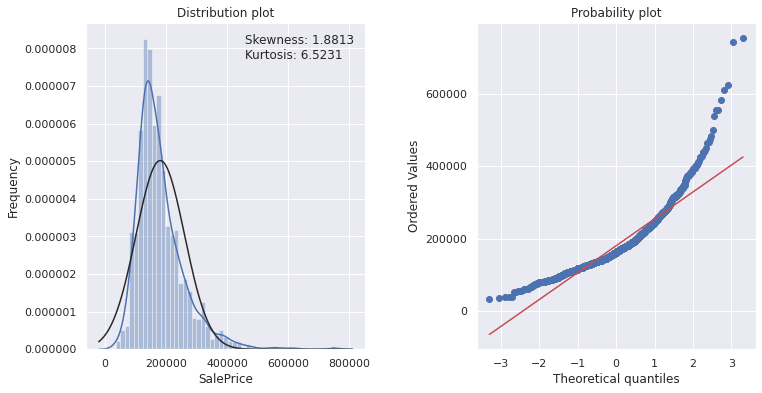

In [9]:
y_train = df_train['SalePrice'].reset_index(drop = True)
print(y_train.describe())
histAndProbPlot(y_train, 'SalePrice')

There are no zero-values, which is great for modelling. However, the results above indicate that there will be a right skew, so it would be beneficial to normalise the data with the log(1+x) transform.

count   1458.000
mean      12.024
std        0.400
min       10.460
25%       11.775
50%       12.002
75%       12.274
max       13.534
Name: SalePrice, dtype: float64


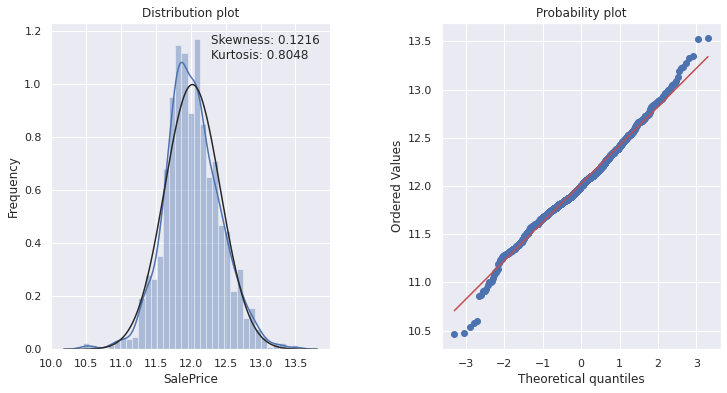

In [10]:
y_train = np.log1p(y_train)
print(y_train.describe())
histAndProbPlot(y_train, 'Normalised SalePrice')

In [11]:
# Sizes before removing SalePrice and combining the datasets
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print('Before concatenating datasets:\ny_train: {}\ndf_train: {}\ndf_test: {}'.format(y_train.shape, df_train.shape, df_test.shape))

# Combine the datasets
df_train.drop(['SalePrice'], axis = 1, inplace = True)
df_allData = pd.concat([df_train, df_test]).reset_index(drop = True)

# Sizes after removing SalePrice and combining the datasets
print('After concatenating datasets:\nt_train: {}\ndf_train: {}\ndf_test: {}'.format(y_train.shape, df_train.shape, df_test.shape))

Before concatenating datasets:
y_train: (1458,)
df_train: (1458, 77)
df_test: (1459, 76)
After concatenating datasets:
t_train: (1458,)
df_train: (1458, 76)
df_test: (1459, 76)


## Impute missing values
I've chosen to do this first, so that any effects it has on relationships or other aspects of this exploration/modeling can be accounted for early on.

In [12]:
def getMissingValues():
    missingValuesTotal = df_allData.isnull().sum().sort_values(ascending = False)
    missingValuesPercent = (100 * df_allData.isnull().sum() / df_allData.isnull().count()).sort_values(ascending = False)

    missingValues = pd.concat([missingValuesTotal, missingValuesPercent], axis = 1, keys = ['# Missing', '% Missing'])
    return missingValues[missingValues['# Missing'] > 0]

getMissingValues()

,# Missing,% Missing
PoolQC,2908,99.691
MiscFeature,2812,96.400
Alley,2719,93.212
Fence,2346,80.425
FireplaceQu,1420,48.680
LotFrontage,486,16.661
GarageYrBlt,159,5.451
GarageFinish,159,5.451
GarageQual,159,5.451
GarageCond,159,5.451


In [13]:
# For each of the following characteristics, data_description.txt notes that NaN values are equivalent to having none of the corresponding characteristic
for var in ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'MasVnrType', 'MiscFeature', 'PoolQC']:
    df_allData[var] = df_allData[var].fillna('NA')

# For each of the following characteristics, data_description.txt notes that NaN values are equivalent to having a zero-quantity of the corresponding characteristic
for var in ['GarageYrBlt', 'MasVnrArea']:
    df_allData[var] = df_allData[var].fillna(0)
    
# In data_description.txt, no substitution is given for NaN LotFrontage characteristics;  thus I'm going to assume they should be zero-quantity values.
for var in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageCars', 'TotalBsmtSF']:
    df_allData[var] = df_allData[var].fillna(0)
    
# In data_description.txt, no substitution is given for NaN LotFrontage characteristics; thus I'm going to use the median values for the row's corresponding neighbourhood.
# This may have issues when a there is a NaN value in a neighbourhood with no other samples, but for now this is not the case.
df_allData['LotFrontage'] = df_allData.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
# For each of the following characteristics, data_description.txt gives no substitution options for NaN values (and there are no equivalent 'N/A' options); thus I will be assigning the 'standard/base' value.
df_allData['Electrical'] = df_allData['Electrical'].fillna('SBrkr')
df_allData['Functional'] = df_allData['Functional'].fillna('Typ')
df_allData['KitchenQual'] = df_allData['KitchenQual'].fillna('TA')

# For each of the following characteristics, data_description.txt gives no substitution options for NaN values (and there are no equivalent 'N/A' options), and there are no standard/base values; thus I will be assigning mode for each characteristic.
for var in ['Exterior1st', 'Exterior2nd', 'MSZoning', 'SaleType', 'Utilities']:
    df_allData[var] = df_allData[var].fillna(df_allData[var].mode()[0])

# Confirm that all missing values have been fixed
getMissingValues()

,# Missing,% Missing


## Clean data types
Change all categorical columns are as noted as numbers to strings.

In [14]:
cols_numToObj = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt',
                 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

for col in cols_numToObj:
    df_train[col] = df_train[col].apply(str)
    df_test[col] = df_test[col].apply(str)
    df_allData[col] = df_allData[col].apply(str)

## Standardising skewed features

Standardise strongly skewed numerical columns in the dataset using the Box Cox transformation.

The following are the skew values for each numerical column:

Numeric columns with Skew > 0.5 [n = 22]:

MiscVal         21.940
PoolArea        17.689
LotArea         13.109
LowQualFinSF    12.085
3SsnPorch       11.372
KitchenAbvGr     4.301
BsmtFinSF2       4.145
EnclosedPorch    4.002
ScreenPorch      3.945
BsmtHalfBath     3.930
MasVnrArea       2.622
OpenPorchSF      2.529
WoodDeckSF       1.845
LotFrontage      1.103
GrLivArea        1.069
BsmtFinSF1       0.981
BsmtUnfSF        0.920
2ndFlrSF         0.862
Fireplaces       0.725
HalfBath         0.697
TotalBsmtSF      0.672
BsmtFullBath     0.622
dtype: float64


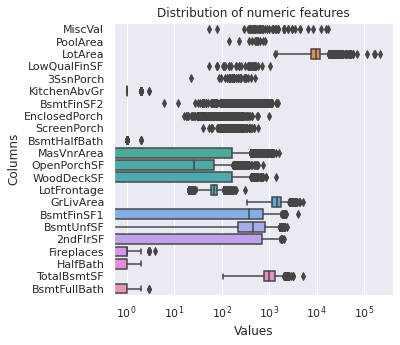

In [15]:
def printSkewedColumns():
    # Numeric columns
    numColumns = df_allData.dtypes[df_allData.dtypes != 'object'].index

    # Find columns with a strong skew
    skewFlag = 0.5
    skewedColumns = df_allData[numColumns].apply(lambda x: skew(x)).sort_values(ascending = False)
    skewedColumns = skewedColumns[skewedColumns > skewFlag]

    print('Numeric columns with Skew > {} [n = {}]:\n\n{}'.format(skewFlag, len(skewedColumns), skewedColumns))
    
    return skewedColumns

    
sC = printSkewedColumns()
boxPlotMultipleColumns(df_allData, sC.index)

And applying the Box Cox transform to columns with skew values > 0.5:

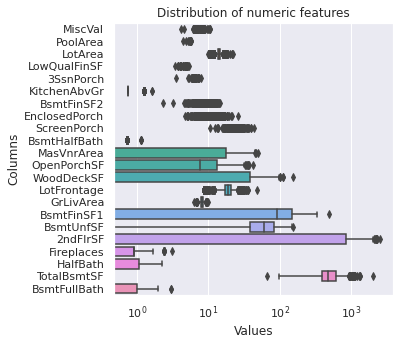

In [16]:
for col in sC.index:
    df_allData[col] = boxcox1p(df_allData[col], boxcox_normmax(df_allData[col] + 1))
    
boxPlotMultipleColumns(df_allData, sC.index)

These results aren't perfectly normal, but they are significantly improved.

## Categorical Values

I shall determine which of the categorical columns can be made numeric through label encoding, or simple type conversions.

In [17]:
cols = df_allData.dtypes[df_allData.dtypes == 'object'].index
print('Categorical columns:\n{}'.format(cols))

Categorical columns:
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')


Columns with ordinal categorical values encoded into numbers:

In [18]:
ordinalColumns = {
# Columns with binary data
    'Street': [['Grvl', 'Pave']],
    'CentralAir': [['N', 'Y']],
# Columns with ordinal data
    'BsmtFinType1': [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']],
    'BsmtFinType2': [['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']],
    'BsmtExposure': [['NA', 'No', 'Mn', 'Av', 'Gd']],
    'PoolQC': [['NA', 'Fa', 'TA', 'Gd', 'Ex']],
    'FireplaceQu': [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'GarageCond': [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'GarageQual': [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'BsmtQual': [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'ExterCond': [['Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'HeatingQC': [['Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'ExterQual': [['Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'KitchenQual': [['Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'BsmtCond': [['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']],
    'GarageFinish': [['NA', 'Unf', 'RFn', 'Fin']],
    'Fence': [['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']],
    'LandSlope': [['Sev', 'Mod', 'Gtl']],
    'LotShape': [['IR3', 'IR2', 'IR1', 'Reg']],
    'Functional': [['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']],
    'PavedDrive': [['N', 'P', 'Y']]
}

for k, i in ordinalColumns.items():
    oe = OrdinalEncoder(categories = i)
    df_allData[k] = oe.fit_transform(df_allData[[k]])

Columns with numeric data, assigned to the wrong data type:

In [19]:
# Columns with numeric data
numericColumns = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                  'GarageYrBlt', 'MoSold', 'YrSold']

for c in numericColumns:    
    df_allData[c] = pd.to_numeric(df_allData[c])

The remaining categorical columns (and their lengths) will have one-hot encoding applied:

In [20]:
cols = df_allData.dtypes[df_allData.dtypes == 'object'].index

print('Length\tColumn')
v = 0
for c in cols:
    vals = df_allData[c].unique()
    v += len(vals)
    print('{}\t{}'.format(len(vals), c))
    
print('\nCurrent columns: {}\nColumns being replaced: {}\nColumns being added: {}\nExpected total columns: {}'.format(
    df_allData.shape[1], len(cols), v, df_allData.shape[1] + v - len(cols)
))

Length	Column
16	MSSubClass
5	MSZoning
3	Alley
4	LandContour
2	Utilities
5	LotConfig
25	Neighborhood
9	Condition1
8	Condition2
5	BldgType
8	HouseStyle
6	RoofStyle
7	RoofMatl
15	Exterior1st
16	Exterior2nd
5	MasVnrType
6	Foundation
6	Heating
5	Electrical
7	GarageType
5	MiscFeature
9	SaleType
6	SaleCondition

Current columns: 76
Columns being replaced: 23
Columns being added: 183
Expected total columns: 236


In [21]:
origShape = df_allData.shape
df_allData = pd.get_dummies(df_allData)
cols = len(df_allData.dtypes[df_allData.dtypes == 'object'].index)
print('Original dataframe size: {}\nNew dataframe size: {}\nRemaining categorical columns: {}'.format(origShape, df_allData.shape, cols))

Original dataframe size: (2917, 76)
New dataframe size: (2917, 236)
Remaining categorical columns: 0


## Modelling

In [22]:
# Import required libraries
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

### Set-up cross validation strategy

In [23]:
# Split df_allData into the test and train components
df_train = df_allData[:n_train]
df_test = df_allData[n_train:]

# Croff validation folds
nFolds = 5
meaningOfLife = 42
kf = KFold(n_splits = nFolds, shuffle = True, random_state = meaningOfLife)

# Cross valisation function
def rmse_crossVal(model):
    rmse = np.sqrt(-cross_val_score(model,
                                    df_train,
                                    y_train,
                                    scoring = 'neg_mean_squared_error',
                                    cv = kf))
    return rmse

# Error metric function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Generate each of the models
And add them into a list, which will be later used to populate a stacking regressor.

In [24]:
models = []

# Light gradient boosting machine
lightGBM  = LGBMRegressor(objective = 'regression',
                          num_leaves = 15,
                          learning_rate = 0.0165,
                          n_estimators = 1250,
                          max_bin = 250,
                          subsample = 0.8,
                          subsample_freq = 5,
                          colsample_bytree = 0.26,
                          min_child_samples = 5)
models.append(('Light GBM', lightGBM))

# eXtreme gradient boosting model
xgBoost = XGBRegressor(n_estimators = 3500,
                       max_depth = 4,
                       learning_rate = 0.06,
                       gamma = 0.052,
                       min_child_weight = 2.095,
                       subsample = 0.52,
                       colsample_bytree = 0.603,
                       reg_alpha = 0.415,
                       reg_lambda = 0.990,
                       nthread = -1)
models.append(('XG Boost', xgBoost))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(loss = 'huber',
                                learning_rate = 0.01,
                                n_estimators = 5000,
                                min_samples_split = 9,
                                min_samples_leaf = 6,
                                max_depth = 3,
                                max_features = 'sqrt',
                                random_state = 42)
models.append(('Gradient Boosting', gbr))

# Calculate the score for each of the above models
names, results = [], []
for m in models:
    names.append(m[0])
    score = rmse_crossVal(m[1])
    results.append(score)
    print('{} Score: {:.4f} ({:.4f})'.format(m[0], score.mean(), score.std()))

Light GBM Score: 0.1128 (0.0066)
XG Boost Score: 0.1160 (0.0096)
Gradient Boosting Score: 0.1107 (0.0074)


Stacked Regressor Score: 0.1097 (0.0083)


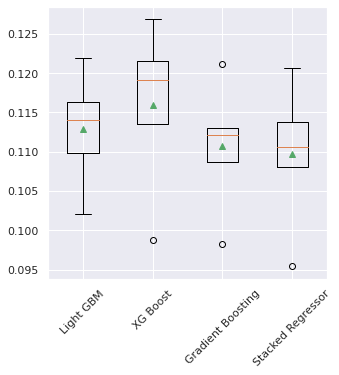

In [25]:
# Stacking regressor, combining each of the previous models
stacking = StackingRegressor(estimators = models,
                             cv = kf,
                             n_jobs = -1)

# Calculate the score for the stacking regressor
names.append('Stacked Regressor')
score = rmse_crossVal(stacking)
results.append(score)
print('{} Score: {:.4f} ({:.4f})'.format('Stacked Regressor', score.mean(), score.std()))

# Generate a boxplot illustrating the differences in scores between each of the models
plt.boxplot(results, labels = names, showmeans = True)
plt.xticks(rotation = 45)
plt.show()

### Testing the stacking regressor
The stacking regressor is the most accurate model, thus we will move forward with evaluating its performance.

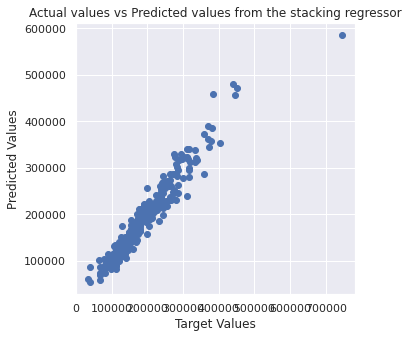

In [26]:
# Split the training data into testing and training subsets
X_modelTrain, X_modelTest, y_modelTrain, y_modelTest = train_test_split(df_train, y_train, random_state = meaningOfLife)
stacking.fit(X_modelTrain, y_modelTrain).score(X_modelTest, y_modelTest)

# Predict outputs from the testing subset, and invert the natural logarithms
y_modelTest_pred = stacking.predict(X_modelTest)
y_modelTest = np.e**y_modelTest - 1
y_modelTest_pred = np.e**y_modelTest_pred - 1

# Plot the actual vs predicted values
plt.scatter(x = y_modelTest, y = y_modelTest_pred)
plt.title('Actual values vs Predicted values from the stacking regressor')
plt.xlabel('Target Values')
plt.ylabel('Predicted Values')
plt.show()

### Output the predictions
The stacking regressor performs well, so I will proceed with predicting sale proces for the test data, and outputting the results to CSV.

In [27]:
y_test = stacking.predict(df_test)
y_test = np.e**y_test - 1

output = pd.DataFrame()
output['Id'] = testingIDs
output['SalePrice'] = y_test
output.to_csv('submission.csv', index = False)